Make the CIV plot, but this time also include the 388/8403 color-selected that overlapped with the LOFAR footprint (Shimwell+2019).

Note that we need to divide our EW values by 1+z to match Amy's

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import astropy
from astropy.io import fits
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
import richardsplot
import sklearn
%matplotlib inline

/Users/trevormccaffrey/anaconda3/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [2]:
#Equations

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

def radluminosity(nu1, nu2, S, alpha, z):
    #calculate luminosity at nu1 based on flux at nu2
    DL = 3.086e24*cosmo.luminosity_distance(z).value
    L = ((4*np.pi*DL**2*(S*1e-23*1e-6)) / ((1+z)**(1+alpha))) * (nu1/nu2)**alpha * 1e-7
    return np.log10(L)

def fluxdensity(nu1, nu2, L, alpha, z):
    #calculate flux density at nu2 based on luminosity at nu1
    L = 10.**L
    DL = 3.086e24*cosmo.luminosity_distance(z).value
    S = L * (nu2/nu1)**alpha * (((1+z)**(1+alpha))/(4*np.pi*DL**2)) * 1e36
    return S #return flux density in microJy

def SFR_L14(L14):
    #Yun+2001 SFR relation based on 1.4GHz luminosity
    return 5.9e-22 * (10**L14)

def SFR_Mi(Mi):
    #Absolute magnitude SFR relation from Harris+2016
    return -29*Mi**2 - 1625*Mi - 22505

def SFR_eqw(E):
    #Equation 8 of Harris+2016 - compute SFR given EQW measurements
    return 4205*E**(-.5) - 328

In [75]:
radluminosity(3., .144, 355, -0.7, 1.65), radluminosity(3., .144, 355, -0.7, 2.1)

(23.755814960874535, 23.99239847607916)

In [77]:
fluxdensity(3., .144, 23.755814960874535, -0.7, 2.1)

205.89454373946134

----

Load in data for 50 VLA objects.  Going to need the following:

- 3-GHz flux densities (they're 1.4-GHz for the two FIRST sources) to be converted to $L_\mathrm{3GHz}$
- $M_i(z=2)$ for the one Harris SFR relation
- EW for the other SFR relation
- C$_\mathrm{IV}$ EW/blueshift to place the quasars in that space

In [3]:
vla = pd.read_csv("../SpringFinalFigs_moreParams.csv")
vla.head()

,Unnamed: 0,col1,name,follow_up,RMS,peak_flux,PFerr,int_flux,IFerr,S/N,...,Separation,ICA_CIV_BLUESHIFT,ICA_CIV_EQW,RM_DIST_UNSCALE,RM_DIST_SCALE,CIV_BLUESHIFT_SCALED,CIV_EQW_SCALED,CIVBestfit_Index,L3GHz [W/Hz],CIV_DIST_021721
0,0,233,SDSSJ001342.45-002412.6,0,9.8,163.0,17.0,219.0,37.0,16.632653,...,0.000422,1488.886594,101.160257,1728.413701,3.486256,0.722760,-0.879689,275801.0,24.469498,3.486282
1,1,293,SDSSJ014023.83+141151.7,0,25.0,516.0,27.0,516.0,27.0,20.640000,...,0.002490,172.315874,95.079534,414.691980,2.589969,-0.319656,-0.943523,238121.0,24.841584,2.589717
2,2,1270,SDSSJ014658.21-091505.2,0,10.0,30.0,NaN,30.0,NaN,NaN,...,0.003016,406.588017,97.289514,646.782974,2.704445,-0.134167,-0.920323,244881.0,23.606351,2.704345
3,3,1281,SDSSJ015720.27-093809.1,0,14.3,42.9,NaN,42.9,NaN,NaN,...,0.003151,557.606423,122.740901,796.239578,2.635625,-0.014596,-0.653142,240918.0,23.761645,2.635554
4,4,7944,SDSSJ081656.84+492438.1,1,8.7,26.1,NaN,26.1,NaN,NaN,...,0.010092,1250.742184,102.881571,1490.190560,3.289717,0.534205,-0.861619,269740.0,23.545828,3.289712


In [35]:
S3 = vla[["int_flux"]].values.flatten()
z_vla = vla[["redshift_1"]].values.flatten()
L3 = radluminosity(3., 3., S3, -0.7, z_vla)
det_vla = (vla[["detection"]].values.flatten()==1)
ew_vla = vla[["ICA_CIV_EQW"]].values.flatten() / (1+z_vla)
voff_vla = vla[["ICA_CIV_BLUESHIFT"]].values.flatten()
Mi_vla = vla[["MI_Z2"]].values.flatten()
SFRavg_vla = (SFR_Mi(Mi_vla) + SFR_eqw(ew_vla)) / 2.

#Compare with catalog values to see what's going on
voff_cat = vla[["VOFF_CIV_PEAK_1"]].values.flatten()
ew_cat = vla[["EW_CIV_1"]].values.flatten()

Now load in parent sample that is in LOFAR footprint

In [5]:
lofar = pd.read_csv("LOFAR_from8403colorselected_all388_CIV.csv")
lofar.sort_values("col1", inplace=True)
lofar_det = pd.read_csv("LOFAR_from8403colorselected_detections123_1arcsec.csv")
lofar_det.sort_values("col1", inplace=True)
lofar_det.head()

,col1,name,RA_1,Dec_1,Source_Name,RA_2,E_RA,E_RA_tot,DEC_2,E_DEC,...,E_DC_Min,PA,E_PA,DC_PA,E_DC_PA,Isl_rms,S_Code,Mosaic_ID,Isl_id,Separation
0,1596,150855.76+543551.1,227.232351,54.597534,ILTJ150855.75+543551.0,227.232303,0.513256,0.545390,54.597517,0.429279,...,0.801843,123.827401,27.231359,123.827401,27.231359,0.115406,S,P227+53,2666,0.117538
1,1597,150458.47+541945.0,226.243631,54.329169,ILTJ150458.36+541944.9,226.243165,0.585375,0.599968,54.329150,0.303656,...,0.562968,111.743927,17.220519,0.000000,17.220519,0.092353,S,P223+55,129,0.980656
2,1598,150636.17+542354.4,226.650744,54.398453,ILTJ150636.20+542354.5,226.650828,0.488406,0.522071,54.398488,0.418312,...,0.978034,99.999269,73.754655,99.999269,73.754655,0.164218,S,P227+53,3362,0.216721
3,1830,110039.04+510902.3,165.162686,51.150642,ILTJ110039.05+510902.2,165.162688,0.136256,0.156984,51.150616,0.144476,...,0.317960,20.380242,55.903120,20.380242,55.903120,0.067429,S,P4Hetdex16,2296,0.093947
4,1832,110853.98+522337.9,167.224924,52.393875,ILTJ110853.96+522337.6,167.224854,0.486835,0.516670,52.393796,0.299093,...,0.700402,84.536970,24.364421,0.000000,24.364421,0.075898,S,P8Hetdex,4605,0.324757


In [6]:
c1 = lofar[["col1"]].values.flatten() #can use this to pick out detections from Amy's file
c1_det = lofar_det[["col1"]].values.flatten()
D_lofar = np.array([])
for i in range(len(c1)):
    if (c1[i]==c1_det).any():
        D_lofar = np.append(D_lofar, True)
    else:
        D_lofar = np.append(D_lofar, False)

det_lofar = (D_lofar==1.)

In [7]:
(det_lofar).sum()

123

Good, we have a mask for all the detections in LOFAR

In [8]:
c1[D_lofar==1]

array([1596, 1597, 1598, 1830, 1832, 1839, 1840, 1842, 1847, 1849, 1853,
       1860, 1861, 1863, 1867, 2206, 2208, 2212, 2219, 2220, 2221, 2226,
       2227, 2230, 2232, 2233, 2234, 2388, 2389, 2392, 2395, 2401, 2403,
       2406, 2409, 2411, 2414, 2415, 2416, 2418, 2419, 2420, 2421, 2422,
       2424, 2425, 2426, 2427, 2432, 2434, 2438, 2439, 2448, 2454, 2455,
       2458, 2521, 2526, 2527, 2529, 2534, 2535, 2536, 2538, 2545, 2546,
       2548, 2549, 2837, 2838, 2842, 2844, 2845, 2846, 2850, 2851, 2852,
       2853, 2854, 2861, 2862, 2866, 2952, 2973, 2982, 2983, 2986, 2989,
       2990, 2991, 3001, 3170, 3426, 3458, 3467, 3468, 3470, 3480, 3482,
       3488, 3510, 3520, 3523, 3535, 3536, 3537, 3912, 3916, 3917, 3921,
       3922, 3924, 3925, 3935, 3936, 3943, 8286, 8398, 8399, 8401, 8404,
       8508, 8519])

In [9]:
S144 = 24.*np.ones(len(lofar)) #initialize all objects to non-detections
S144[det_lofar] = lofar_det[["Total_flux"]].values.flatten()
z_lofar = lofar[["z_paul"]].values.flatten()
L3_lofar = radluminosity(3., 0.144, S144, -0.7, z_lofar)
ew_lofar = lofar[["CIV_EW"]].values.flatten()
voff_lofar = lofar[["CIV_blue"]].values.flatten()

In [10]:
rm = pd.read_csv("../RM_CIV_Ordering/SDSSRMMedianCIVParams_wCIVDist.csv")
rm.head()

,Unnamed: 0,RMID_1,RA,DEC,PSFMAG,FIBER2MAG,OBJC_TYPE,ZPIP,ZSYS,ZSYS_ERR,...,SIGMA,SIGMA_ERR,SIGMA_ERR_WARNING,col1,RMID_2,Median_CIV_Blueshift,Median_CIV_EQW,RM_DIST_UNSCALE,RM_DIST_SCALE,CIV_DIST_021721
0,0,10,213.764157,52.922335,"(22.532715, 20.543663, 20.141333, 19.901579, 1...","(23.24768, 21.35396, 20.95871, 20.71041, 20.55...",6,3.2299,3.238099,0.003555,...,0.0,-1.0,0,2,10.0,3043.601724,38.746729,3284.052565,4.854122,4.879626
1,1,11,213.892516,52.962006,"(20.520481, 20.502234, 20.364378, 20.174232, 2...","(21.31451, 21.33308, 21.18767, 20.97824, 20.83...",6,2.0543,2.052707,0.002459,...,0.0,-1.0,0,3,11.0,120.040272,114.026327,361.244787,2.446265,2.542369
2,2,19,213.873727,52.868186,"(20.681818, 20.364162, 20.384111, 20.117191, 1...","(21.47477, 21.17687, 21.1949, 20.91205, 20.78988)",6,1.9166,1.918346,0.002037,...,0.0,-1.0,0,5,19.0,358.184681,70.264077,600.363857,2.812054,2.840095
3,3,31,214.170380,53.115956,"(19.870947, 19.98295, 19.924612, 19.675512, 19...","(20.71221, 20.82329, 20.79188, 20.53111, 20.4844)",6,1.9090,1.907144,0.002047,...,0.0,-1.0,0,8,31.0,211.038542,112.873362,451.038471,2.497235,2.562650
4,4,34,213.225037,53.137408,"(20.235037, 20.16954, 20.047485, 19.84725, 19....","(21.07218, 20.9689, 20.8534, 20.65883, 20.51734)",6,1.8250,1.824840,0.002086,...,0.0,-1.0,0,9,34.0,1061.001110,74.051041,1301.267477,3.254224,3.270599


In [11]:
z_rm = rm[["ZSYS"]].values.flatten()
voff_rm = rm[["Median_CIV_Blueshift"]].values.flatten()
ew_rm = rm[["Median_CIV_EQW"]].values.flatten() / (1+z_rm)

In [12]:
fit = np.load("RM_CIV_bestFitLine_noScale.npy")
fit[:,1] /= (1+np.median(z_vla))

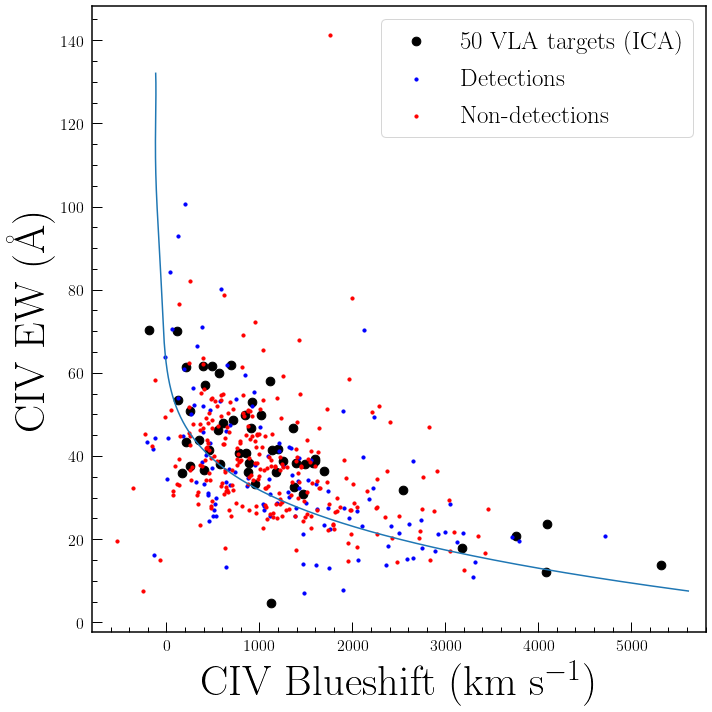

In [15]:
fig = plt.figure(figsize=(10,10))

plt.plot(fit[:,0], fit[:,1])
#plt.scatter(voff_lofar, ew_lofar, color="b", s=25, label="LOFAR", alpha=0.4)
plt.scatter(voff_vla, ew_vla, color="k", s=75, label="50 VLA targets (ICA)")
#plt.scatter(voff_cat, ew_cat, color="g", s=45, label="50 VLA targets (DR7)")
#plt.scatter(voff_rm, ew_rm, color="r", s=25, label="SDSS-RM", alpha=0.4)
plt.scatter(voff_lofar[det_lofar], ew_lofar[det_lofar], color="b", s=10, label="Detections")
plt.scatter(voff_lofar[~det_lofar], ew_lofar[~det_lofar], color="r", s=10, label="Non-detections")

plt.xlabel("CIV Blueshift (km s$^{-1}$)", fontsize=42.5)
plt.ylabel("CIV EW (Å)", fontsize=42.5)
plt.legend(loc="best", prop={'size': 25})
plt.xlim(-800,5800)
#plt.ylim(-10,350)

#Limits from paper
#plt.xlim(-800,5800)
#plt.ylim(-20,390)
plt.tight_layout()
#plt.savefig("CIVPlot_wLOFAR_rawZ.pdf")
plt.show()

Maybe should remake the best-fit line at some point (and do we we still want to include the RM objects as "control?"), but some things we can do:

- Compute the CIV distance for the new LOFAR targets, then compute detection fractions of LOFAR objects to compare/augment our own -- it may be useful to consider "detections" as those above *our* sensitivity in the VLA observations, to avoid evolution effects (i.e. use luminosity cutoff not flux)

- Remake CIV plots (maybe with LOFAR points added, but that's alot) -- can check SF excess or deficiency for larger number of targets now

- Could maybe (/should?) filter out the objects Amy classified as having "bad" reconstructions

In [15]:
a = np.array([[0,1]])
b = np.array([[3,4]])
c = np.concatenate((a,b), axis=0)
c

array([[0, 1],
       [3, 4]])

In [51]:
#Want to put all data on the same scale to compute dimensionless CIV "distance"
vlad = np.array([voff_vla, ew_vla]).T #
lofd = np.array([voff_lofar, ew_lofar]).T
rmd = np.array([voff_rm, ew_rm]).T
data = np.concatenate((vlad, lofd, rmd, fit), axis=0)
data

array([[1488.88659422,   38.16560229],
       [ 172.31587372,   35.87418363],
       [ 406.58801663,   36.70118434],
       ...,
       [5613.48605984,    7.54533776],
       [5613.61216272,    7.54496053],
       [5613.73826784,    7.5445833 ]])

In [52]:
from sklearn.preprocessing import scale
scale_data = scale(data)
scale_data

array([[ 0.72234649, -0.87838531],
       [-0.32025324, -0.94214906],
       [-0.13473181, -0.91913595],
       ...,
       [ 3.98863991, -1.73046131],
       [ 3.98873977, -1.73047181],
       [ 3.98883963, -1.73048231]])

In [53]:
len(vlad), len(lofd), len(rmd)

(50, 388, 133)

In [70]:
vla_sc = scale_data[:len(vlad),:]
lofar_sc = scale_data[len(vlad):(len(vlad)+len(lofd)),:]
rm_sc = scale_data[(len(vlad)+len(lofd)):(len(vlad)+len(lofd)+len(rmd))]
fit_sc = scale_data[(len(vlad)+len(lofd)+1+len(rmd)):]

In [82]:
len(lofar_sc)

388

In [93]:
def trevorFit(data, fit):
    #Use: Project scattered data (data) onto a line of best fit (fit)
    #Returns: 2-D array of (x,y) locations on the line of your orthogonal projection
    
    #data: 2-D (N by 2) array of your data in some x-y space
    #fit: 2-D (N by 2) array of coordinates along your line of best fit
    
    trevorFit = np.array([]).reshape(0, 2) 
    
    for scat in data: 
        r = np.sqrt((scat[0]-fit[:,0])**2 + (scat[1]-fit[:,1])**2) #dist of data point from each point along fit
        delta = np.array([fit[np.argmin(r), 0], fit[np.argmin(r), 1]]) #we want to take the index of fit where
        trevorFit = np.concatenate((trevorFit, np.atleast_2d(delta)))  #the displacement was minimum (min r)
        
    return trevorFit


def sudo_pca(fit, data):
    #fit: 2-D array containing coordinates of points along best fit line ([cz, cfit(cz)] here)
    #data: 2-D [x,y] array of data (N by 2 shape)
    #NOTE: This really just caters to this situation (assumes monotonically decreasing function)
    
    data = trevorFit(data, fit) #project data onto fit
    
    #
    if fit[0,1] < fit[-1,1]: #Compare EQW at endpoints [Blueshift, EQW] - want fit[0,1] to be top left of plot
        fit  = np.flip(fit, axis=0)
    
    darr = [] #list to fill with distances for each point

    for scat in data:
        d = 0 #start at beginning of the line
        for i in range(fit.shape[0]-1):
            xp, x = fit[i,0], fit[i+1,0]
            yp, y = fit[i,1], fit[i+1,1] 
            dp = d
            d += np.sqrt((x-xp)**2 + (y-yp)**2)
            if yp >= scat[1] >= y: #if we pass the projected y-coord, save the distance traveled
                darr.append(d)
                break
                
    return np.array(darr).reshape(len(darr),1)

## Cell below takes a while! (but <10 minutes)

In [94]:
vla_dist = sudo_pca(fit_sc, vla_sc)
lof_dist = sudo_pca(fit_sc, lofar_sc)
rm_dist = sudo_pca(fit_sc, rm_sc)

In [96]:
vla["CIV_DIST_021721"] = vla_dist
rm["CIV_DIST_021721"] = rm_dist
lofar["CIV_DIST_021721"] = lof_dist

vla.to_csv("../SpringFinalFigs_moreParams.csv")
rm.to_csv("../RM_CIV_Ordering/SDSSRMMedianCIVParams_wCIVDist.csv")
lofar.to_csv("LOFAR_from8403colorselected_all388_CIV.csv")

OK, now that we have CIV distance for all objects, I need to go back and see how Gordon defined his boundaries for "low-blueshift high-EW" etc when discussing detections fractions through CIV space.  Then, a simple mask will let us compute detection fractions in the LOFAR objects

Question: How did Gordon compute the uncertainty to our 44% detection fraction (at the beginning of Section 6)?

We have three regions:

- High EW (>140Å -- although now in rest-frame translates to >54Å) --- CIV dist < X
- Moderate EW/blueshift --- X < CIV < Y
- High blueshift (defined by the 6 highest-blueshift VLA sources) --- CIV dist > Y

It turns out these values are X~2.3 and Y~4


In [109]:
lofar_low = (lof_dist<2.3).flatten()
lofar_mid = ((lof_dist>2.3)&(lof_dist<4.)).flatten()
lofar_high = (lof_dist>4.).flatten()
lofar_low.sum(), lofar_mid.sum(), lofar_high.sum()

(31, 299, 58)

In [113]:
print("High-blueshift/low-EW detection fraction = ", (det_lofar&lofar_high).sum() / lofar_high.sum())
print("Mid-blueshift/EW detection fraction      = ", (det_lofar&lofar_mid).sum() / lofar_mid.sum())
print("Low-blueshift/High EW detection fraction = ", (det_lofar&lofar_low).sum() / lofar_low.sum())

High-blueshift/low-EW detection fraction =  0.4827586206896552
Mid-blueshift/EW detection fraction      =  0.27424749163879597
Low-blueshift/High EW detection fraction =  0.41935483870967744


In [110]:
(det_lofar&lofar_low).sum()

13

In [108]:
(lofar_low&det_lofar).shape

(388, 388)

In [ ]:
fig = plt.figure(figsize=(10,10))

plt.plot(fit[:,0], fit[:,1])
#plt.scatter(voff_lofar, ew_lofar, color="b", s=25, label="LOFAR", alpha=0.4)
plt.scatter(voff_vla, ew_vla, color="k", s=75, label="50 VLA targets (ICA)")
#plt.scatter(voff_cat, ew_cat, color="g", s=45, label="50 VLA targets (DR7)")
#plt.scatter(voff_rm, ew_rm, color="r", s=25, label="SDSS-RM", alpha=0.4)
plt.scatter(voff_lofar[det_lofar], ew_lofar[det_lofar], color="b", s=10, label="Detections")
plt.scatter(voff_lofar[~det_lofar], ew_lofar[~det_lofar], color="r", s=10, label="Non-detections")

plt.xlabel("CIV Blueshift (km s$^{-1}$)", fontsize=42.5)
plt.ylabel("CIV EW (Å)", fontsize=42.5)
plt.legend(loc="best", prop={'size': 25})
plt.xlim(-800,5800)
#plt.ylim(-10,350)

#Limits from paper
#plt.xlim(-800,5800)
#plt.ylim(-20,390)
plt.tight_layout()
#plt.savefig("CIVPlot_wLOFAR_rawZ.pdf")
plt.show()

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


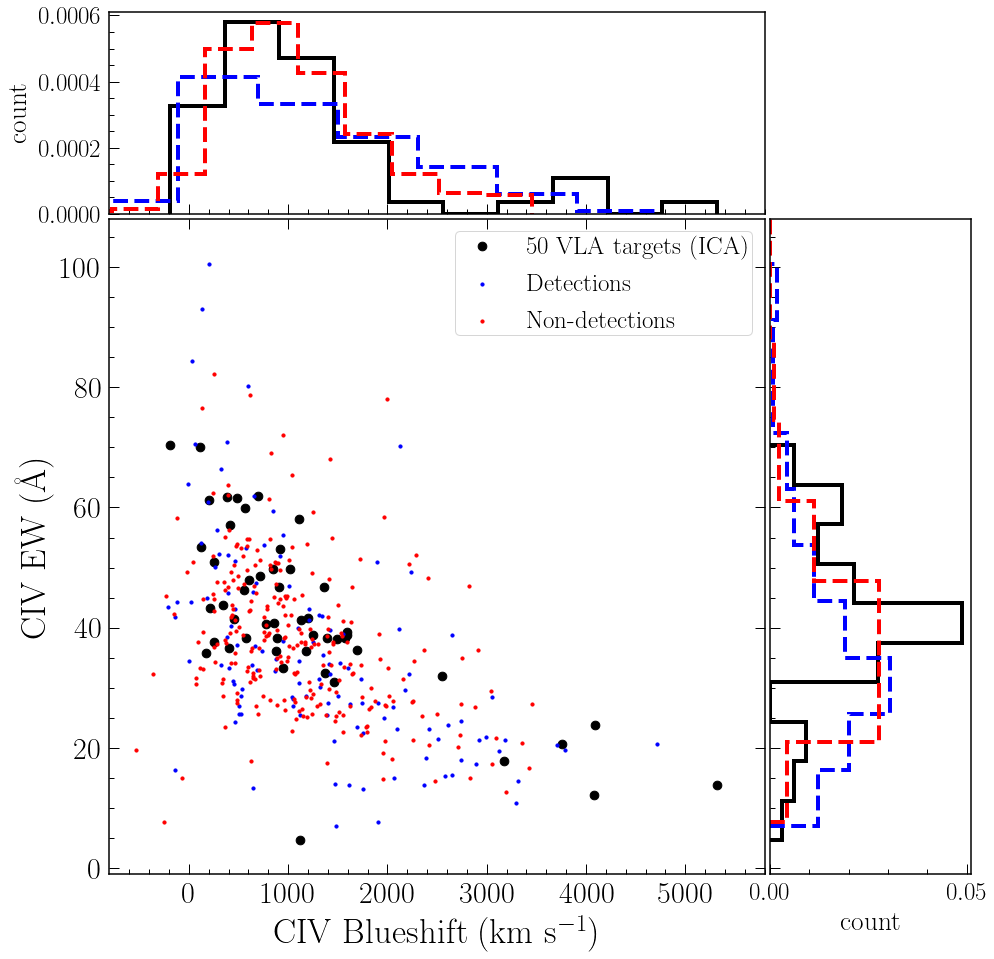

In [25]:
#ratbins = np.linspace(min(flux_ratio), max(flux_ratio), 21)

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(14, 14))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)


#Plot scatter data
ax_scatter.scatter(voff_vla, ew_vla, color="k", s=75, label="50 VLA targets (ICA)")
ax_scatter.scatter(voff_lofar[det_lofar], ew_lofar[det_lofar], color="b", s=10, label="Detections")
ax_scatter.scatter(voff_lofar[~det_lofar], ew_lofar[~det_lofar], color="r", s=10, label="Non-detections")

xlims = ax_scatter.get_xlim() #Save limits before plotting
ax_scatter.set_xlim(-800,5800)
ax_scatter.set_ylim(-1,108)

#ax_scatter.set_yscale("log")
#ax_scatter.set_xlim(xlims)
ax_scatter.tick_params(axis='both', which='major', labelsize=25)


#Plot x axis distribution
ax_histx.hist(voff_vla,align='mid', histtype="step", linewidth=4.0, color="k", density=True)
ax_histx.hist(voff_lofar[det_lofar],align='mid', histtype="step", linewidth=4.0, ls="--", color="b",
              density=True)
ax_histx.hist(voff_lofar[~det_lofar],align='mid', histtype="step", linewidth=4.0, ls="--", color="r", 
              density=True)
ax_histx.set_ylabel('count', fontsize=27.5)
ax_histx.tick_params(axis='both', which='major', labelsize=25)

ax_histy.hist(ew_vla,orientation='horizontal',align='mid', histtype="step", linewidth=4.0,
             color="k", density=True)
ax_histy.hist(ew_lofar[det_lofar],orientation='horizontal',align='mid', histtype="step", 
              color="b", linewidth=4.0, linestyle="--", density=True)
ax_histy.hist(ew_lofar[~det_lofar],orientation='horizontal',align='mid', histtype="step", 
              color="r", linewidth=4.0, linestyle="--", density=True)
histy_xlims = ax_histy.get_xlim()
#ax_histy.plot([0,20], [1,1], "-k", alpha=0.8)
ax_histy.set_xlabel('count', fontsize=27.5)
ax_histy.tick_params(axis='both', which='major', labelsize=25)

ax_scatter.set_xlabel("CIV Blueshift (km s$^{-1}$)", fontsize=35)
ax_scatter.set_ylabel("CIV EW (Å)", fontsize=35)
ax_scatter.legend(loc="upper right", prop={"size": 25}, borderpad=0.1)
#ax_scatter.set_xlim(22.40, 25.07)
ax_scatter.tick_params(axis='both', which='major', labelsize=30)

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())
ax_histy.set_xlim(histy_xlims)
#ax_histx.set_xscale("log")
#ax_histy.set_yscale("log")
plt.tight_layout()
#plt.savefig("PaperPlots/fluxratioscat_whistos.pdf")
plt.show()

Try looking at the LOFAR points as contours now so we can also colorcode our VLA objects but keep them separate in the figure

In [36]:
#Get density estimations of LOFAR  
#data to plot contours in plot below

from scipy.stats import gaussian_kde

xmin, xmax = voff_lofar[det_lofar].min(), voff_lofar[det_lofar].max()
ymin, ymax = ew_lofar[det_lofar].min(), ew_lofar[det_lofar].max()
X1, Y1 = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X1.ravel(), Y1.ravel()])
values = np.vstack([voff_lofar[det_lofar], ew_lofar[det_lofar]])
kernel = gaussian_kde(values)
Z1 = np.reshape(kernel(positions).T, X1.shape)

xmin, xmax = voff_lofar[~det_lofar].min(), voff_lofar[~det_lofar].max()
ymin, ymax = ew_lofar[~det_lofar].min(), ew_lofar[~det_lofar].max()
X2, Y2 = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X2.ravel(), Y2.ravel()])
values = np.vstack([voff_lofar[~det_lofar], ew_lofar[~det_lofar]])
kernel = gaussian_kde(values)
Z2 = np.reshape(kernel(positions).T, X2.shape)

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


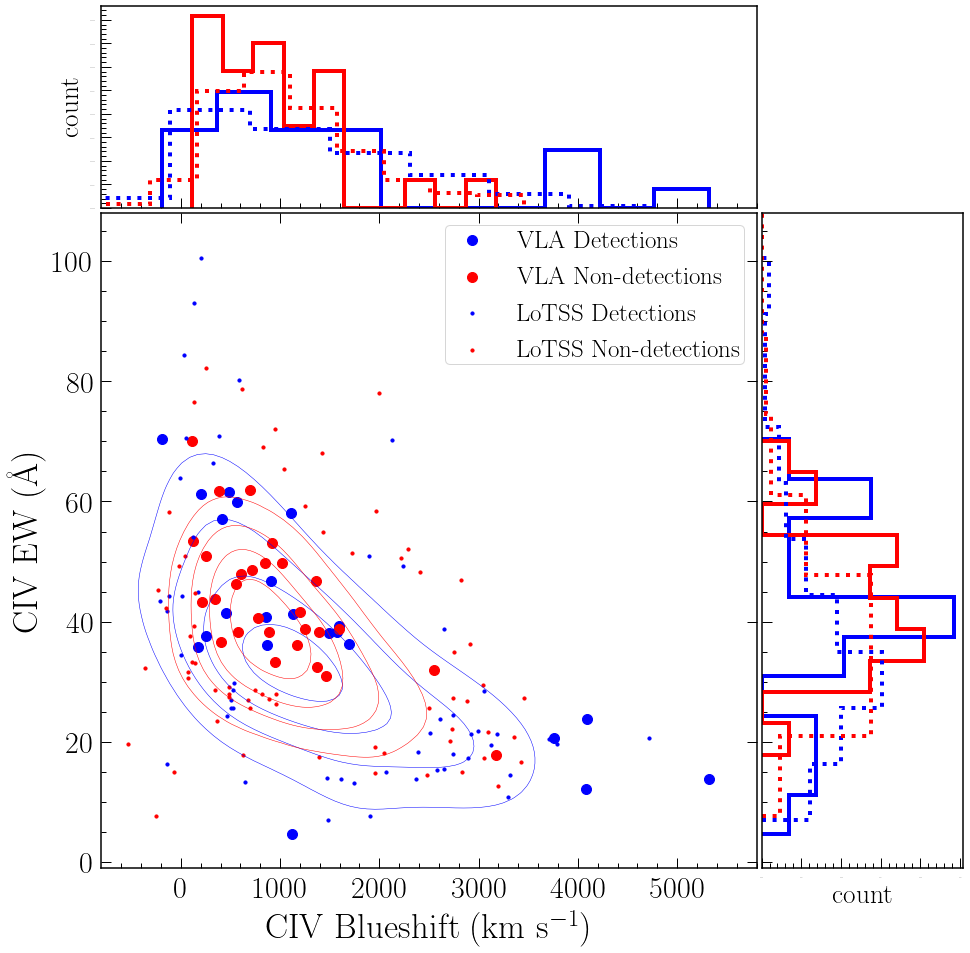

In [68]:
#ratbins = np.linspace(min(flux_ratio), max(flux_ratio), 21)

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(14, 14))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)


#Plot scatter data
ax_scatter.scatter(voff_vla[det_vla], ew_vla[det_vla], color="b", s=100, label="VLA Detections")
ax_scatter.scatter(voff_vla[~det_vla], ew_vla[~det_vla], color="r", s=100, label="VLA Non-detections")
#ax_scatter.scatter(voff_lofar[det_lofar], ew_lofar[det_lofar], color="b", s=10, label="LoTSS Detections")
#ax_scatter.scatter(voff_lofar[~det_lofar], ew_lofar[~det_lofar], color="r", s=10, label="LoTSS Non-detections")
ax_scatter.contour(X1, Y1, Z1, levels=4, linewidths=0.5, colors='b')
ax_scatter.contour(X2, Y2, Z2, levels=4, linewidths=0.5, colors='r')
#Plot these points around the contours
contmask = ((ew_lofar>65)|(ew_lofar<20)|(voff_lofar>3250)|(voff_lofar<200)|((ew_lofar>50)&(voff_lofar>1250)) \
           |((ew_lofar>40)&(voff_lofar>1800))|((ew_lofar>20)&(voff_lofar>2500))|((ew_lofar<30)&(voff_lofar<1000)))
ax_scatter.scatter(voff_lofar[(det_lofar&contmask)], ew_lofar[det_lofar&contmask], 
                   color="b", s=10, label="LoTSS Detections")
ax_scatter.scatter(voff_lofar[(~det_lofar&contmask)], ew_lofar[~det_lofar&contmask], 
                   color="r", s=10, label="LoTSS Non-detections")

xlims = ax_scatter.get_xlim() #Save limits before plotting
ax_scatter.set_xlim(-800,5800)
ax_scatter.set_ylim(-1,108)

#ax_scatter.set_yscale("log")
#ax_scatter.set_xlim(xlims)
ax_scatter.tick_params(axis='both', which='major', labelsize=25)


#Plot x axis distribution
ax_histx.hist(voff_vla[det_vla],align='mid', histtype="step", linewidth=4.0, color="b", density=True)
ax_histx.hist(voff_vla[~det_vla],align='mid', histtype="step", linewidth=4.0, color="r", density=True)
ax_histx.hist(voff_lofar[det_lofar],align='mid', histtype="step", linewidth=4.0, ls=":", color="b",
              density=True)
ax_histx.hist(voff_lofar[~det_lofar],align='mid', histtype="step", linewidth=4.0, ls=":", color="r", 
              density=True)
ax_histx.set_ylabel('count', fontsize=27.5)
ax_histx.tick_params(axis='both', which='major', labelsize=0)

ax_histy.hist(ew_vla[det_vla],orientation='horizontal',align='mid', histtype="step", linewidth=4.0,
             color="b", density=True)
ax_histy.hist(ew_vla[~det_vla],orientation='horizontal',align='mid', histtype="step", linewidth=4.0,
             color="r", density=True)
ax_histy.hist(ew_lofar[det_lofar],orientation='horizontal',align='mid', histtype="step", 
              color="b", linewidth=4.0, linestyle=":", density=True)
ax_histy.hist(ew_lofar[~det_lofar],orientation='horizontal',align='mid', histtype="step", 
              color="r", linewidth=4.0, linestyle=":", density=True)
histy_xlims = ax_histy.get_xlim()
#ax_histy.plot([0,20], [1,1], "-k", alpha=0.8)
ax_histy.set_xlabel('count', fontsize=27.5)
ax_histy.tick_params(axis='both', which='major', labelsize=0)

ax_scatter.set_xlabel("CIV Blueshift (km s$^{-1}$)", fontsize=35)
ax_scatter.set_ylabel("CIV EW (Å)", fontsize=35)
ax_scatter.legend(loc="upper right", prop={"size": 25}, borderpad=0.1)
#ax_scatter.set_xlim(22.40, 25.07)
ax_scatter.tick_params(axis='both', which='major', labelsize=30)

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())
ax_histy.set_xlim(histy_xlims)
#ax_histx.set_xscale("log")
#ax_histy.set_yscale("log")
plt.tight_layout()
plt.savefig("CIV_wLOFARcontours_whistos.pdf")
plt.show()

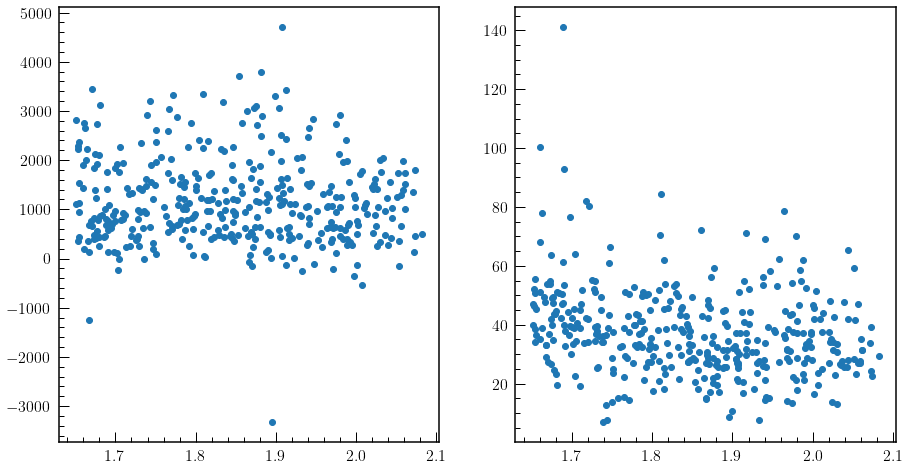

In [76]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15,8))

ax1.scatter(z_lofar, voff_lofar)
ax2.scatter(z_lofar, ew_lofar)